# MLP idea

In [376]:
import os
import torch
import math
print(f"PyTorch has version {torch.__version__} with cuda {torch.version.cuda}")

PyTorch has version 2.3.1+cu121 with cuda 12.1


In [377]:
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Input

In [378]:
# Define material properties
Vs_values = np.array([140,250,1000,1500,2000,100,500,800,950,2500], dtype=float)
f_values = np.array([1, 1.5, 1.75, 2.25, 3], dtype=float)
t_values = np.linspace(0.5, 2.5, 10)

# Create a list of all possible combinations of Vs, f, and t
Vs_val, f_val, t_val = np.meshgrid(Vs_values, f_values, t_values, indexing='ij')
Vs_val = Vs_val.flatten()
f_val = f_val.flatten()
t_val = t_val.flatten()

# Create array with the combinations
data = np.array([Vs_val, f_val, t_val]).T

# Read all csv files from folder
folder_path = r"FLAC\FLAC2D - Case 1a\data"
files = os.listdir(folder_path)
files = [f for f in files if f.endswith('.csv')]

In [379]:
# Create DataSet class
class MyDataset(Dataset):
    def __init__(self, data, folder_path):
        self.data = data
        self.folder_path = folder_path

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Read the file
        file = files[idx]
        df = pd.read_csv(os.path.join(self.folder_path, file))
        # Get the data
        target = df.values[:, 2:]
        # Get the target
        input_2 = self.data[idx]

        # Get the additional input
        freq1 = input_2[1]
        t01 = input_2[2]
        t = df.values[:, 0]
        wave = -2*freq1**2*np.pi**2*np.exp(-freq1**2*np.pi**2*(t01 - t)**2)*(t01 - t)*(2*freq1**2*np.pi**2*t01**2 - 4*freq1**2*np.pi**2*t01*t + 2*freq1**2*np.pi**2*t**2 - 3)
        input_1 = wave
    
        # Get final input
        input_2 = input_2[0] * np.ones((30,))

        # Convert to tensor
        input_1 = torch.tensor(input_1, dtype=torch.float32)
        input_2 = torch.tensor(input_2, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.float32).squeeze()
        
        return input_1, input_2, target

In [380]:
import torch
from torch.utils.data import DataLoader, random_split

# Assuming MyDataset is already defined and data is loaded
dataset = MyDataset(data, folder_path)

# Define the sizes for training, validation, and testing sets
train_size = int(0.9 * len(dataset))
val_size = int(0.05 * len(dataset))
test_size = len(dataset) - train_size - val_size
print(train_size, val_size, test_size)

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for each set
batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Check the first batch of the training set
for i, (input_1, input_2, target) in enumerate(train_loader):
    print("Training set:", input_1.shape, input_2.shape, target.shape)
    break

# Check the first batch of the validation set
for i, (input_1, input_2, target) in enumerate(val_loader):
    print("Validation set:", input_1.shape, input_2.shape, target.shape)
    break

# Check the first batch of the testing set
for i, (input_1, input_2, target) in enumerate(test_loader):
    print("Testing set:", input_1.shape, input_2.shape, target.shape)
    break

450 25 25
Training set: torch.Size([2, 1500]) torch.Size([2, 30]) torch.Size([2, 1500])
Validation set: torch.Size([2, 1500]) torch.Size([2, 30]) torch.Size([2, 1500])
Testing set: torch.Size([2, 1500]) torch.Size([2, 30]) torch.Size([2, 1500])


In [381]:
# Create Model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_layers, output_dim, activation=nn.ReLU, batch_norm=False):
        super(MLP, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.batch_norm = batch_norm
        self.activation = activation

        # Input layer
        self.hidden_layers.append(nn.Linear(input_dim, hidden_dim))
        if self.batch_norm:
            self.hidden_layers.append(nn.BatchNorm1d(hidden_dim))

        # Hidden layers
        for _ in range(hidden_layers - 1):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
            if self.batch_norm:
                self.hidden_layers.append(nn.BatchNorm1d(hidden_dim))

        # Output layer
        self.out = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        for layer in self.hidden_layers:
            if isinstance(layer, nn.Linear):
                x = layer(x)
                x = self.activation()(x)
            elif isinstance(layer, nn.BatchNorm1d):
                x = layer(x)
        x = self.out(x)
        return x

In [382]:
# Create simple 1D CNN MLP model
class CNN_1D_MLP(nn.Module):
    def __init__(self, input_size, input_channels, hidden_dim, hidden_layers, hidden_conv_layers, output_size, kernel_size, stride, padding, 
                 activation=nn.ReLU, batch_norm=False):
        super(CNN_1D_MLP, self).__init__()

        self.batch_norm = batch_norm
        self.activation = activation

        # Convolutional layers
        conv_layers = []
        for _ in range(hidden_conv_layers):
            conv_layers.append(nn.Conv1d(input_channels, input_channels, kernel_size, stride, padding))
            if self.batch_norm:
                conv_layers.append(nn.BatchNorm1d(input_channels))
            conv_layers.append(self.activation())
        self.conv_layers = nn.Sequential(*conv_layers)

        # Flatten the output
        self.flatten = nn.Flatten()

        # Fully connected layers
        fc_layers = []
        for _ in range(hidden_layers):
            fc_layers.append(nn.Linear(input_size, hidden_dim))
            if self.batch_norm:
                fc_layers.append(nn.BatchNorm1d(hidden_dim))
            fc_layers.append(self.activation())
            input_size = hidden_dim
        self.hidden_layers = nn.Sequential(*fc_layers)

        # Output layer
        self.out = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.hidden_layers(x)
        x = self.out(x)
        return x

In [383]:
class Model(nn.Module):
    def __init__(self, input_Vs, input_acc, output_dim, batch_norm=False):
        super(Model, self).__init__()
        self.mlp1 = MLP(input_Vs, 100, 3, 20, batch_norm=batch_norm)
        #self.mlp2 = CNN_1D_MLP(input_acc, 1, 100, 3, 2, 30, 3, 1, 1, batch_norm=batch_norm)
        self.mlp2 = MLP(input_acc, 100, 3, 20, batch_norm=batch_norm)
        self.mlp3 = MLP(40, 100, 5, output_dim, batch_norm=batch_norm)
        
        self.output_dim = output_dim
        #self.output_channels = output_channels

    def forward(self, acc, Vs):
        x1 = self.mlp1(Vs)
        x2 = self.mlp2(acc)
        #x2 = self.mlp2(acc.unsqueeze(1))
        x = torch.cat((x1, x2), dim=1)
        x = self.mlp3(x)
        #x = x.view(-1, self.output_dim, self.output_channels)
        return x

In [384]:
for i, (input_1, input_2, target) in enumerate(train_loader):
    print("Training set:", input_1.shape, input_2.shape, target.shape)
    break

Training set: torch.Size([2, 1500]) torch.Size([2, 30]) torch.Size([2, 1500])


In [385]:
# Check model

for i, (input_1, input_2, target) in enumerate(train_loader):
    break

print(input_1.shape, input_2.shape, target.shape)

model = Model(input_Vs=30, input_acc=1500, output_dim=1500)
pred = model(Vs=input_2, acc=input_1)
assert pred.shape == target.shape, f"Expected shape {target.shape} but got {pred.shape}"

# Define the loss function
loss_fn = nn.MSELoss()
loss = loss_fn(pred, target)
print(loss)

torch.Size([2, 1500]) torch.Size([2, 30]) torch.Size([2, 1500])
tensor(6.7873, grad_fn=<MseLossBackward0>)


In [386]:
# Early stopping
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [400]:
import torch
from tqdm import trange
import logging


def train(model, loss_function, optimizer, scheduler, train_dataloader, val_dataloader, epochs=100, device="cpu", patience=5, log_interval=10):
    model.to(device)
    train_losses = []
    val_losses = []
    scaler = torch.cuda.amp.GradScaler()  # For mixed precision training
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    # Set up logging
    logging.basicConfig(filename='training.log', level=logging.INFO, filemode='w')
    logging.info('Starting training...')

    for epoch in trange(epochs, desc="Training", unit="Epoch"):
        model.train()
        running_train_loss = 0.0
        for X1, X2, y in train_dataloader:
            X1, X2, y = X1.to(device, non_blocking=True), X2.to(device, non_blocking=True), y.to(device, non_blocking=True)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():  # Mixed precision context
                #y_pred = model(X1, X2)
                y_pred = model(X1)
                single_loss = loss_function(y_pred, y)
            scaler.scale(single_loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_train_loss += single_loss.item()
        
        avg_train_loss = running_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        for X1, X2, y in val_dataloader:
            X1, X2, y = X1.to(device, non_blocking=True), X2.to(device, non_blocking=True), y.to(device, non_blocking=True)
            with torch.no_grad():
                with torch.cuda.amp.autocast():  # Mixed precision context
                    #y_pred = model(X1, X2)
                    y_pred = model(X1)
                single_loss = loss_function(y_pred, y)
                running_val_loss += single_loss.item()
        
        avg_val_loss = running_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)

        # Update the learning rate
        scheduler.step()

        if epoch % log_interval == 0:
            log_message = f'Epoch: {epoch:3} Train Loss: {avg_train_loss:10.8f} Val Loss: {avg_val_loss:10.8f}'
            print(log_message)
            logging.info(log_message)

        # Check early stopping condition
        early_stopping(avg_val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            logging.info("Early stopping")
            break

    logging.info('Training complete.')
    return train_losses, val_losses, model

In [401]:
# Define test function
def test(model, dataloader, device="cpu", loss_function=nn.MSELoss()):
    model.to(device)
    model.eval()
    predictions = []
    total_loss = 0
    with torch.no_grad():
        for X1, X2, y in dataloader:
            X1, X2, y = X1.to(device), X2.to(device), y.to(device)
            y_pred = model(X1, X2)
            predictions.append(y_pred)
            # Loss
            loss = loss_function(y_pred, y)
            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return predictions, avg_loss

In [402]:
#model = Model(input_Vs=30, input_acc=1500, output_dim=1500, batch_norm=False)
model = MLP(input_dim=1500, hidden_dim=100, hidden_layers=3, output_dim=1500, batch_norm=False)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

In [404]:
# Check size of input
for i, (X1, X2, y) in enumerate(train_loader):
    print(f"X1 shape: {X1.shape}, X2 shape: {X2.shape}, y shape: {y.shape}")
    #pred = model(X1, X2)
    pred = model(X1)
    print(f"Prediction shape: {pred.shape}, y shape: {y.shape}")
    loss = loss_function(pred, y)
    print(f"Loss: {loss}")
    break

X1 shape: torch.Size([2, 1500]), X2 shape: torch.Size([2, 30]), y shape: torch.Size([2, 1500])
Prediction shape: torch.Size([2, 1500]), y shape: torch.Size([2, 1500])
Loss: 6.15317964553833


In [405]:
# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


In [406]:
# Train the model
train_losses, val_losses, model = train(model, loss_function, optimizer, scheduler, train_loader, val_loader, epochs=1000, device=device, patience=50)

Training:   0%|          | 1/1000 [00:13<3:50:59, 13.87s/Epoch]

Epoch:   0 Train Loss: 6.64261449 Val Loss: 5.83627881


Training:   0%|          | 4/1000 [00:22<1:11:22,  4.30s/Epoch]

EarlyStopping counter: 1 out of 50


Training:   0%|          | 5/1000 [00:25<1:04:10,  3.87s/Epoch]

EarlyStopping counter: 2 out of 50


Training:   1%|          | 7/1000 [00:31<55:42,  3.37s/Epoch]  

EarlyStopping counter: 1 out of 50


Training:   1%|          | 8/1000 [00:33<50:26,  3.05s/Epoch]

EarlyStopping counter: 2 out of 50


Training:   1%|          | 9/1000 [00:36<49:44,  3.01s/Epoch]

EarlyStopping counter: 3 out of 50


Training:   1%|          | 11/1000 [00:42<47:42,  2.89s/Epoch]

Epoch:  10 Train Loss: 6.09102898 Val Loss: 5.35280418
EarlyStopping counter: 1 out of 50


Training:   1%|          | 12/1000 [00:44<44:15,  2.69s/Epoch]

EarlyStopping counter: 2 out of 50


Training:   1%|▏         | 13/1000 [00:46<42:15,  2.57s/Epoch]

EarlyStopping counter: 3 out of 50


Training:   1%|▏         | 14/1000 [00:52<55:18,  3.37s/Epoch]

EarlyStopping counter: 4 out of 50


Training:   2%|▏         | 15/1000 [00:55<58:12,  3.55s/Epoch]

EarlyStopping counter: 5 out of 50


Training:   2%|▏         | 16/1000 [01:00<1:01:43,  3.76s/Epoch]

EarlyStopping counter: 6 out of 50


Training:   2%|▏         | 17/1000 [01:04<1:01:51,  3.78s/Epoch]

EarlyStopping counter: 7 out of 50


Training:   2%|▏         | 18/1000 [01:08<1:05:38,  4.01s/Epoch]

EarlyStopping counter: 8 out of 50


Training:   2%|▏         | 19/1000 [01:13<1:07:21,  4.12s/Epoch]

EarlyStopping counter: 9 out of 50


Training:   2%|▏         | 20/1000 [01:17<1:08:57,  4.22s/Epoch]

EarlyStopping counter: 10 out of 50


Training:   2%|▏         | 21/1000 [01:22<1:11:10,  4.36s/Epoch]

Epoch:  20 Train Loss: 5.95344316 Val Loss: 5.22723049
EarlyStopping counter: 11 out of 50


Training:   2%|▏         | 23/1000 [01:31<1:12:39,  4.46s/Epoch]

EarlyStopping counter: 1 out of 50


Training:   2%|▏         | 24/1000 [01:35<1:13:16,  4.50s/Epoch]

EarlyStopping counter: 2 out of 50


Training:   2%|▎         | 25/1000 [01:40<1:13:15,  4.51s/Epoch]

EarlyStopping counter: 3 out of 50


Training:   3%|▎         | 26/1000 [01:44<1:10:19,  4.33s/Epoch]

EarlyStopping counter: 4 out of 50


Training:   3%|▎         | 27/1000 [01:48<1:08:24,  4.22s/Epoch]

EarlyStopping counter: 5 out of 50


Training:   3%|▎         | 28/1000 [01:52<1:10:08,  4.33s/Epoch]

EarlyStopping counter: 6 out of 50


Training:   3%|▎         | 30/1000 [02:02<1:13:52,  4.57s/Epoch]

EarlyStopping counter: 1 out of 50


Training:   3%|▎         | 31/1000 [02:07<1:13:53,  4.58s/Epoch]

Epoch:  30 Train Loss: 5.89436647 Val Loss: 5.20885060
EarlyStopping counter: 2 out of 50


Training:   3%|▎         | 32/1000 [02:11<1:13:15,  4.54s/Epoch]

EarlyStopping counter: 3 out of 50


Training:   3%|▎         | 33/1000 [02:16<1:13:38,  4.57s/Epoch]

EarlyStopping counter: 4 out of 50


Training:   4%|▎         | 35/1000 [02:25<1:13:35,  4.58s/Epoch]

EarlyStopping counter: 1 out of 50


Training:   4%|▎         | 36/1000 [02:29<1:13:22,  4.57s/Epoch]

EarlyStopping counter: 2 out of 50


Training:   4%|▎         | 37/1000 [02:34<1:12:00,  4.49s/Epoch]

EarlyStopping counter: 3 out of 50


Training:   4%|▍         | 39/1000 [02:43<1:13:01,  4.56s/Epoch]

EarlyStopping counter: 1 out of 50


Training:   4%|▍         | 40/1000 [02:47<1:12:17,  4.52s/Epoch]

EarlyStopping counter: 2 out of 50


Training:   4%|▍         | 41/1000 [02:52<1:12:07,  4.51s/Epoch]

Epoch:  40 Train Loss: 5.86416725 Val Loss: 5.23485723
EarlyStopping counter: 3 out of 50


Training:   4%|▍         | 42/1000 [02:56<1:11:14,  4.46s/Epoch]

EarlyStopping counter: 4 out of 50


Training:   4%|▍         | 43/1000 [03:00<1:10:42,  4.43s/Epoch]

EarlyStopping counter: 5 out of 50


Training:   4%|▍         | 44/1000 [03:05<1:09:36,  4.37s/Epoch]

EarlyStopping counter: 6 out of 50


Training:   4%|▍         | 45/1000 [03:09<1:08:52,  4.33s/Epoch]

EarlyStopping counter: 7 out of 50


Training:   5%|▍         | 46/1000 [03:13<1:06:55,  4.21s/Epoch]

EarlyStopping counter: 8 out of 50


Training:   5%|▍         | 47/1000 [03:17<1:07:29,  4.25s/Epoch]

EarlyStopping counter: 9 out of 50


Training:   5%|▍         | 48/1000 [03:21<1:07:22,  4.25s/Epoch]

EarlyStopping counter: 10 out of 50


Training:   5%|▍         | 49/1000 [03:26<1:07:53,  4.28s/Epoch]

EarlyStopping counter: 11 out of 50


Training:   5%|▌         | 50/1000 [03:30<1:07:58,  4.29s/Epoch]

EarlyStopping counter: 12 out of 50


Training:   5%|▌         | 51/1000 [03:34<1:07:46,  4.28s/Epoch]

Epoch:  50 Train Loss: 5.84382745 Val Loss: 5.20742266
EarlyStopping counter: 13 out of 50


Training:   5%|▌         | 52/1000 [03:39<1:06:57,  4.24s/Epoch]

EarlyStopping counter: 14 out of 50


Training:   5%|▌         | 53/1000 [03:43<1:07:56,  4.30s/Epoch]

EarlyStopping counter: 15 out of 50


Training:   5%|▌         | 54/1000 [03:47<1:05:49,  4.18s/Epoch]

EarlyStopping counter: 16 out of 50


Training:   6%|▌         | 55/1000 [03:49<58:12,  3.70s/Epoch]  

EarlyStopping counter: 17 out of 50


Training:   6%|▌         | 56/1000 [03:52<53:35,  3.41s/Epoch]

EarlyStopping counter: 18 out of 50


Training:   6%|▌         | 57/1000 [03:55<49:07,  3.13s/Epoch]

EarlyStopping counter: 19 out of 50


Training:   6%|▌         | 58/1000 [03:57<46:45,  2.98s/Epoch]

EarlyStopping counter: 20 out of 50


Training:   6%|▌         | 59/1000 [04:00<45:12,  2.88s/Epoch]

EarlyStopping counter: 21 out of 50


Training:   6%|▌         | 60/1000 [04:03<44:00,  2.81s/Epoch]

EarlyStopping counter: 22 out of 50


Training:   6%|▌         | 61/1000 [04:05<44:17,  2.83s/Epoch]

Epoch:  60 Train Loss: 5.83251422 Val Loss: 5.30591248
EarlyStopping counter: 23 out of 50


Training:   6%|▌         | 62/1000 [04:08<43:48,  2.80s/Epoch]

EarlyStopping counter: 24 out of 50


Training:   6%|▋         | 63/1000 [04:11<42:51,  2.74s/Epoch]

EarlyStopping counter: 25 out of 50


Training:   6%|▋         | 64/1000 [04:13<42:34,  2.73s/Epoch]

EarlyStopping counter: 26 out of 50


Training:   6%|▋         | 65/1000 [04:16<42:09,  2.71s/Epoch]

EarlyStopping counter: 27 out of 50


Training:   7%|▋         | 66/1000 [04:19<41:31,  2.67s/Epoch]

EarlyStopping counter: 28 out of 50


Training:   7%|▋         | 67/1000 [04:21<41:52,  2.69s/Epoch]

EarlyStopping counter: 29 out of 50


Training:   7%|▋         | 68/1000 [04:24<39:38,  2.55s/Epoch]

EarlyStopping counter: 30 out of 50


Training:   7%|▋         | 69/1000 [04:27<41:14,  2.66s/Epoch]

EarlyStopping counter: 31 out of 50


Training:   7%|▋         | 70/1000 [04:32<54:40,  3.53s/Epoch]

EarlyStopping counter: 32 out of 50


Training:   7%|▋         | 71/1000 [04:37<1:02:45,  4.05s/Epoch]

Epoch:  70 Train Loss: 5.82564915 Val Loss: 5.27078419
EarlyStopping counter: 33 out of 50


Training:   7%|▋         | 72/1000 [04:43<1:08:12,  4.41s/Epoch]

EarlyStopping counter: 34 out of 50


Training:   7%|▋         | 73/1000 [04:48<1:12:52,  4.72s/Epoch]

EarlyStopping counter: 35 out of 50


Training:   7%|▋         | 74/1000 [04:53<1:15:18,  4.88s/Epoch]

EarlyStopping counter: 36 out of 50


Training:   8%|▊         | 75/1000 [04:59<1:17:23,  5.02s/Epoch]

EarlyStopping counter: 37 out of 50


Training:   8%|▊         | 76/1000 [05:04<1:19:05,  5.14s/Epoch]

EarlyStopping counter: 38 out of 50


Training:   8%|▊         | 77/1000 [05:09<1:19:56,  5.20s/Epoch]

EarlyStopping counter: 39 out of 50


Training:   8%|▊         | 78/1000 [05:15<1:20:37,  5.25s/Epoch]

EarlyStopping counter: 40 out of 50


Training:   8%|▊         | 79/1000 [05:20<1:20:15,  5.23s/Epoch]

EarlyStopping counter: 41 out of 50


Training:   8%|▊         | 80/1000 [05:26<1:22:34,  5.39s/Epoch]

EarlyStopping counter: 42 out of 50


Training:   8%|▊         | 81/1000 [05:31<1:21:47,  5.34s/Epoch]

Epoch:  80 Train Loss: 5.82121084 Val Loss: 5.18139669
EarlyStopping counter: 43 out of 50


Training:   8%|▊         | 82/1000 [05:36<1:21:28,  5.32s/Epoch]

EarlyStopping counter: 44 out of 50


Training:   8%|▊         | 83/1000 [05:41<1:20:34,  5.27s/Epoch]

EarlyStopping counter: 45 out of 50


Training:   8%|▊         | 84/1000 [05:47<1:20:45,  5.29s/Epoch]

EarlyStopping counter: 46 out of 50


Training:   8%|▊         | 85/1000 [05:52<1:19:59,  5.25s/Epoch]

EarlyStopping counter: 47 out of 50


Training:   9%|▊         | 86/1000 [05:57<1:19:58,  5.25s/Epoch]

EarlyStopping counter: 48 out of 50


Training:   9%|▊         | 87/1000 [06:02<1:19:51,  5.25s/Epoch]

EarlyStopping counter: 49 out of 50


Training:   9%|▊         | 87/1000 [06:08<1:04:22,  4.23s/Epoch]

EarlyStopping counter: 50 out of 50
Early stopping


Text(0.5, 1.0, 'Training Loss')

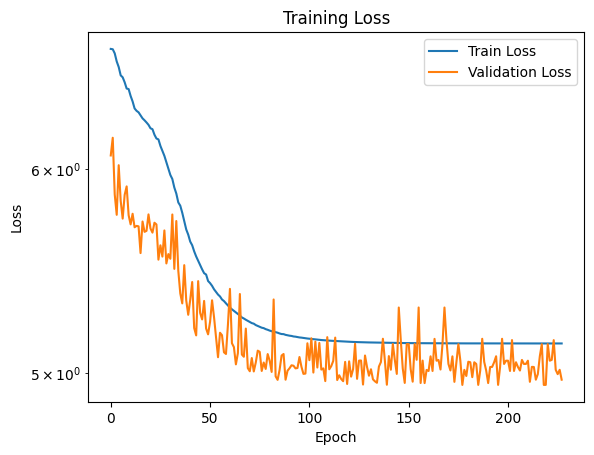

In [393]:
# Plot the losses
import seaborn as sns
sns.lineplot(x=range(len(train_losses)), y=train_losses, label="Train Loss")
sns.lineplot(x=range(len(val_losses)), y=val_losses, label="Validation Loss")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")

Test Loss: 6.300220086024358
Test Loss per batch: 8.4163818359375


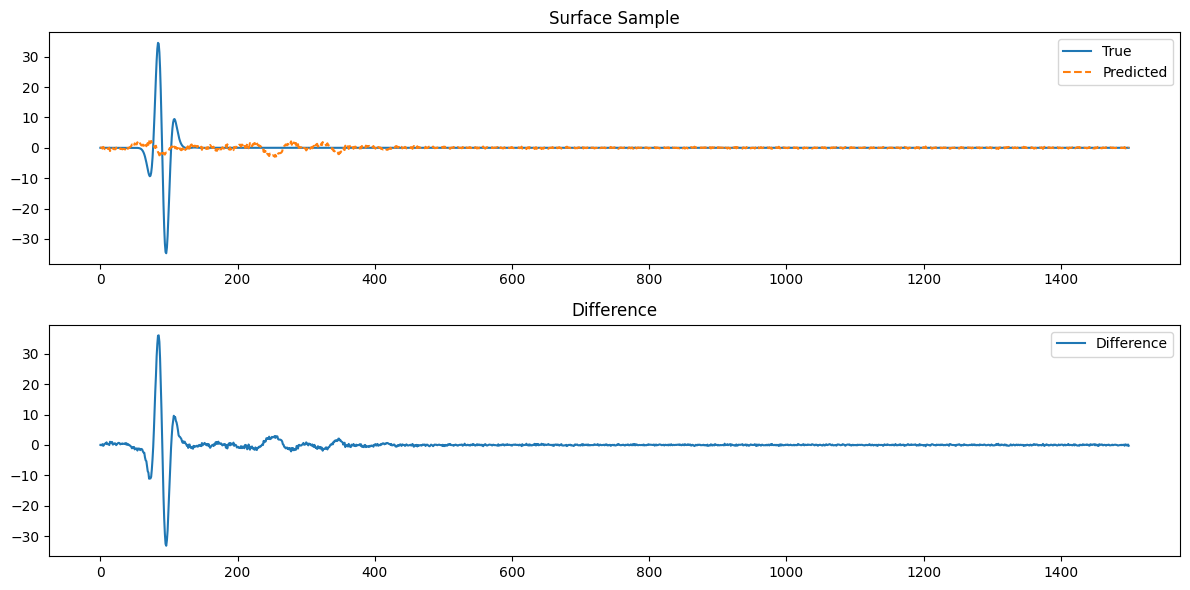

In [394]:
# Test the model
predictions, test_loss = test(model, test_loader, device=device)
print(f"Test Loss: {test_loss}")


for i, (X1, X2, y) in enumerate(test_loader):
    print("Test Loss per batch:", loss_function(predictions[i], y.to(device)).item())

    # Plot the first sample
    if i == 0:
        break

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(y[0,:].cpu(), label="True")
plt.plot(predictions[i][0,:].cpu().detach(), label="Predicted", linestyle="--")
plt.legend()
plt.title("Surface Sample")

plt.subplot(2, 1, 2)
diff = y[0,:].cpu() - predictions[i][0,:].cpu().detach()
plt.plot(diff, label="Difference")
plt.legend()
plt.title("Difference")
plt.tight_layout()
plt.show()
    
